# Eye for Blind

In [1]:
#Import all the required libraries
import pandas as pd
from skimage import io
pd.set_option('display.max_colwidth',-1) # Set the max column width to see the complete caption

import collections
from wordcloud import WordCloud,STOPWORDS

import tensorflow as tf
import keras
from keras.preprocessing.image import load_img
import string
import time
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import Input
from tqdm import tqdm
from PIL import Image

<ipython-input-1-c050996282be>:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth',-1) # Set the max column width to see the complete caption


Let's read the dataset


## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions



In [2]:
#Import the dataset and read the image into a seperate variable
import glob
images='flickr8k/images'

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


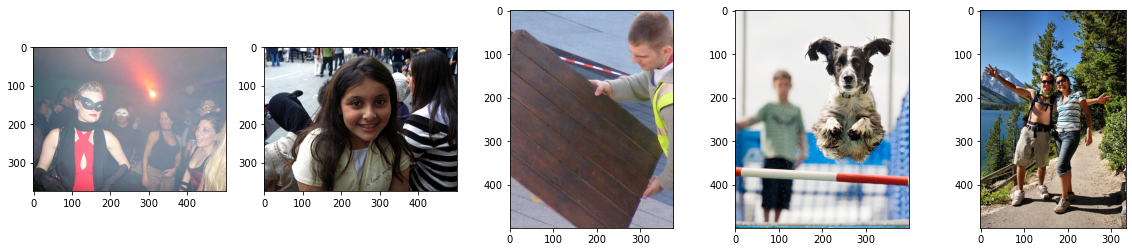

In [3]:
#Visualise both the images & text present in the dataset
import matplotlib.pyplot as plt
Display_Images= all_imgs[0:5]
figure, axes = plt.subplots(1,5)
figure.set_figwidth(20)
   
for ax,image in zip(axes, Display_Images):
    ax.imshow(io.imread(image), cmap=None)

In [4]:
#Import the dataset and read the text file into a seperate variable
text_file = 'flickr8k/captions.txt'
def load_doc(filename):
    #your code here
    open_file = open(text_file, 'r', encoding="UTF-8")
    text = open_file.read()
    print(text)
    open_file.close()
    return text

doc = load_doc(text_file)
print(doc[:300])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [5]:
## checking doc
doc = load_doc(text_file)
print(doc[:10])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Create a dataframe which summarizes the image, path & captions as a dataframe
Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [6]:
## Creating dataset
all_img_id=[]  #store all the image id here
all_img_vector=[] #store all the image path here
annotations= []#store all the captions here

with open('flickr8K/captions.txt', 'r') as file:
    next(file) # to skip the heading 
    for line in file:
        split_char=line.split(',')
        all_img_id.append(split_char[0])
        annotations.append(split_char[1].split('.')[0]) #striping \n and fullstop
        all_img_vector.append('flickr8K/Images/'+split_char[0])
        
df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df.head()

ID                                       Path  \
0  1000268201_693b08cb0e.jpg  flickr8K/Images/1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg  flickr8K/Images/1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg  flickr8K/Images/1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg  flickr8K/Images/1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg  flickr8K/Images/1000268201_693b08cb0e.jpg   

                                                                  Captions  
0  A child in a pink dress is climbing up a set of stairs in an entry way   
1  A girl going into a wooden building                                      
2  A little girl climbing into a wooden playhouse                           
3  A little girl climbing the stairs to her playhouse                       
4  A little girl in a pink dress going into a wooden cabin

In [8]:
## checking unique entries
df.nunique()

ID          8091 
Path        8091 
Captions    39929
dtype: int64

In [9]:
## shape
df.shape

(40455, 3)

In [10]:
#Create a list which contains all the captions
annotations= df['Captions'].tolist()
#add the <start> & <end> token to all those captions as well
annotations = annotations=['<start>' + ' ' +  line + ' ' + '<end>' for line in annotations]

#Create a list which contains all the path to the images
all_img_path= df['Path'].tolist()
## printing total captions and images
print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


In [11]:
#Create the vocabulary & the counter for the captions
## importing counter
from collections import Counter
## vocalbulary
vocabulary= [word.lower() for line in annotations for word in line.split()]
## value count of the vocabulary 
val_count=Counter(vocabulary)
val_count

Counter({'<start>': 40455,
         'a': 60193,
         'child': 1507,
         'in': 18173,
         'pink': 702,
         'dress': 332,
         'is': 9069,
         'climbing': 490,
         'up': 1215,
         'set': 105,
         'of': 6495,
         'stairs': 109,
         'an': 2325,
         'entry': 1,
         'way': 48,
         '<end>': 40455,
         'girl': 3277,
         'going': 145,
         'into': 1046,
         'wooden': 278,
         'building': 485,
         'little': 1736,
         'playhouse': 6,
         'the': 17507,
         'to': 3005,
         'her': 1102,
         'cabin': 4,
         'black': 3620,
         'dog': 7946,
         'and': 8053,
         'spotted': 36,
         'are': 3365,
         'fighting': 130,
         'tri-colored': 12,
         'playing': 1953,
         'with': 7302,
         'each': 399,
         'other': 667,
         'on': 10355,
         'road': 380,
         'white': 3706,
         'brown': 2456,
         'spots': 28,
        

In [12]:
#Visualise the top 30 occuring words in the captions
## importing libraries
import seaborn as sns
from nltk import FreqDist
## defining function plot_word_frequency to plot top 30 occuring words in the captions
def plot_word_frequency(words, top_n=30):
    word_freq = FreqDist(words)
    labels = [element[0] for element in word_freq.most_common(top_n)] ## list comprehension
    counts = [element[1] for element in word_freq.most_common(top_n)] ## list comprehension
    plot = sns.barplot(labels, counts)
    return plot

/Users/abhinavjoshi/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


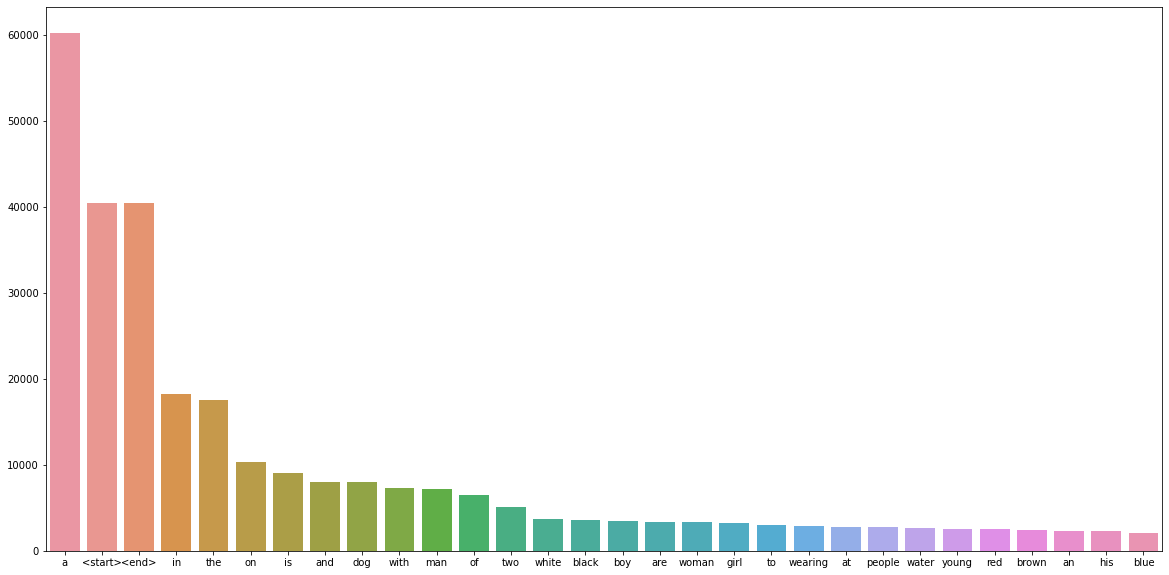

In [13]:
## plotting the top 30 occuring words in the captions
plt.figure(figsize=(20,10))
plot_word_frequency(vocabulary)
plt.show()

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions for example :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [14]:
# create the tokenizer
from keras.preprocessing.text import Tokenizer
## defining special charecters that will not be considered while tokenising
special_chars = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ '
## instatiating tokenzer
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=5000+1,
                                                  oov_token="UNK",
                                                  filters=special_chars,lower=True)
## fitting on captions/annotation
tokenizer.fit_on_texts(annotations)
# Adding PAD to tokenizer list
tokenizer.word_index['PAD'] = 0
tokenizer.index_word[0] = 'PAD'

In [20]:
## creating the tokenized vector 
tok_vector = tokenizer.texts_to_sequences(annotations)

In [15]:
# Create word-to-index and index-to-word mappings.
## word to index mapping
def word_to_index(word):
    print("Word = {}, Index = {}".format(word, tokenizer.word_index[word]))

print( "Word to index mapping")
word_to_index("<start>")
word_to_index("PAD")

Word to index mapping
Word = <start>, Index = 3
Word = PAD, Index = 0


In [16]:
## index-to-word mapping
def index_to_word(index):
    print('Index={},Word={}'.format(index, tokenizer.index_word[index]))
print('Index to word maping')
index_to_word(32)
index_to_word(25)

Index to word maping
Index=32,Word=dogs
Index=25,Word=young


In [17]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing
## importing operator
import operator
## instatiating word_count
word_count = tokenizer.word_counts
word_count = sorted(word_count.items(), key=operator.itemgetter(1),reverse=True)
## top 30 words
top_30 = word_count[:30]
## creating dataframe of the top 30 words
top_30_df = pd.DataFrame(top_30, columns=['Word','Frequency'])
top_30_df

Word  Frequency
0   a        61428    
1   <start>  40455    
2   <end>    40455    
3   in       18190    
4   the      17676    
5   on       10348    
6   is       9069     
7   and      8062     
8   dog      7921     
9   with     7306     
10  man      7164     
11  of       6503     
12  two      5550     
13  white    3727     
14  black    3638     
15  boy      3531     
16  are      3365     
17  woman    3316     
18  girl     3279     
19  to       3007     
20  wearing  2917     
21  people   2831     
22  at       2820     
23  young    2610     
24  red      2570     
25  water    2554     
26  brown    2483     
27  an       2358     
28  his      2255     
29  blue     2135

/Users/abhinavjoshi/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


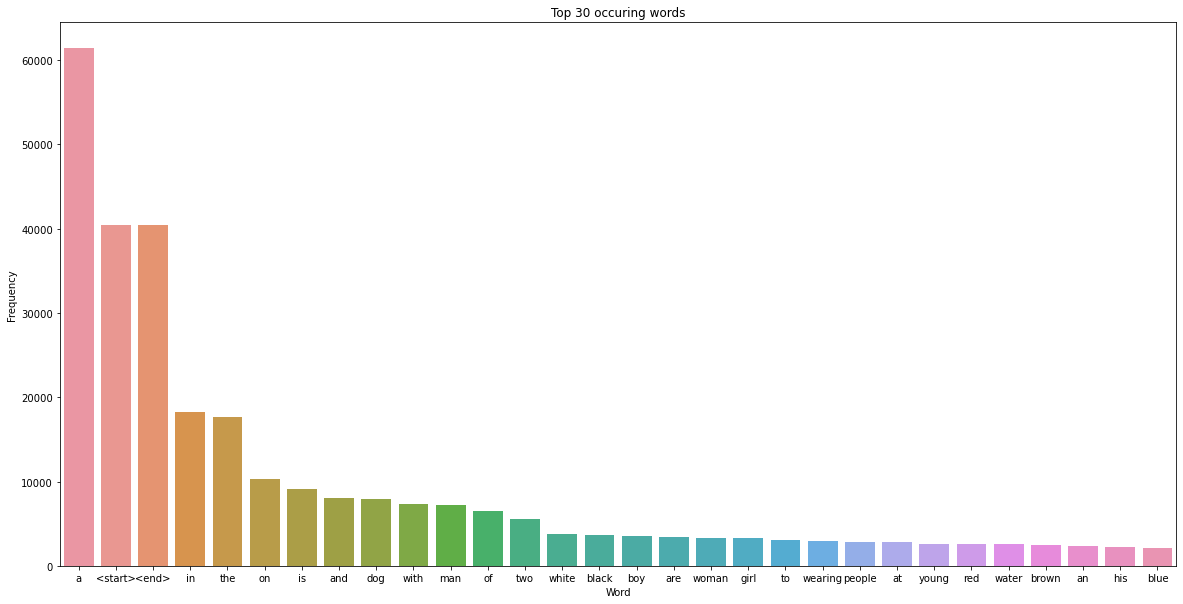

In [18]:
## plotting 
plt.figure(figsize=(20,10))
sns.barplot(top_30_df['Word'],top_30_df['Frequency'])
plt.title('Top 30 occuring words')
plt.show()

In [21]:
# Pad each vector to the max_length of the captions ^ store it to a vairable
## creating cap_vector
cap_vector= tf.keras.preprocessing.sequence.pad_sequences(tok_vector, padding='post')

print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 35)


## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

### FAQs on how to resize the images::
* Since you have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once you have created a dataset consisting of image paths, you need to apply a function to the dataset which will apply the necessary preprocessing to each image. 
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.

In [27]:
#write your code here to create the dataset consisting of image paths
path_dataset = tf.data.Dataset.from_tensor_slices(df['Path'])
for element in path_dataset:
  print(element)

tf.Tensor(b'flickr8K/Images/1000268201_693b08cb0e.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/1000268201_693b08cb0e.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/1000268201_693b08cb0e.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/1000268201_693b08cb0e.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/1000268201_693b08cb0e.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/1001773457_577c3a7d70.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/1001773457_577c3a7d70.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/1001773457_577c3a7d70.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/1001773457_577c3a7d70.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/1001773457_577c3a7d70.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/1002674143_1b742ab4b8.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/1002674143_1b742ab4b8.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/1002674143_1

tf.Tensor(b'flickr8K/Images/1262077938_8b9516c273.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/1262077938_8b9516c273.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/1262077938_8b9516c273.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/1262077938_8b9516c273.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/1262454669_f1caafec2d.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/1262454669_f1caafec2d.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/1262454669_f1caafec2d.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/1262454669_f1caafec2d.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/1262454669_f1caafec2d.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/1262583859_653f1469a9.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/1262583859_653f1469a9.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/1262583859_653f1469a9.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/1262583859_6

tf.Tensor(b'flickr8K/Images/1415591512_a84644750c.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/1415591512_a84644750c.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/1417031097_ab656bc4bd.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/1417031097_ab656bc4bd.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/1417031097_ab656bc4bd.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/1417031097_ab656bc4bd.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/1417031097_ab656bc4bd.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/1417295167_5299df6db8.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/1417295167_5299df6db8.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/1417295167_5299df6db8.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/1417295167_5299df6db8.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/1417295167_5299df6db8.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/141755290_4b

tf.Tensor(b'flickr8K/Images/1522787272_5a31497ef2.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/1522787272_5a31497ef2.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/1522787272_5a31497ef2.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/1523800748_a59e980eee.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/1523800748_a59e980eee.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/1523800748_a59e980eee.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/1523800748_a59e980eee.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/1523800748_a59e980eee.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/1523984678_edd68464da.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/1523984678_edd68464da.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/1523984678_edd68464da.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/1523984678_edd68464da.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/1523984678_e

tf.Tensor(b'flickr8K/Images/191003284_1025b0fb7d.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/191003284_1025b0fb7d.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/191003284_1025b0fb7d.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/191003285_edd8d0cf58.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/191003285_edd8d0cf58.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/191003285_edd8d0cf58.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/191003285_edd8d0cf58.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/191003285_edd8d0cf58.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/191003287_2915c11d8e.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/191003287_2915c11d8e.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/191003287_2915c11d8e.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/191003287_2915c11d8e.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/191003287_2915c11d8e.jpg

tf.Tensor(b'flickr8K/Images/2089122314_40d5739aef.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2089122314_40d5739aef.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2089122314_40d5739aef.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2089350172_dc2cf9fcf6.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2089350172_dc2cf9fcf6.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2089350172_dc2cf9fcf6.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2089350172_dc2cf9fcf6.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2089350172_dc2cf9fcf6.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2089426086_7acc98a3a8.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2089426086_7acc98a3a8.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2089426086_7acc98a3a8.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2089426086_7acc98a3a8.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2089426086_7

tf.Tensor(b'flickr8K/Images/2196050115_e236d91f52.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2196050115_e236d91f52.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2196050115_e236d91f52.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2196050115_e236d91f52.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2196107384_361d73a170.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2196107384_361d73a170.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2196107384_361d73a170.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2196107384_361d73a170.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2196107384_361d73a170.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2196284168_76417efbec.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2196284168_76417efbec.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2196284168_76417efbec.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2196284168_7

tf.Tensor(b'flickr8K/Images/2266061169_dfbf8f0595.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/226607225_44d696db6b.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/226607225_44d696db6b.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/226607225_44d696db6b.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/226607225_44d696db6b.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/226607225_44d696db6b.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2266142543_b2de18c081.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2266142543_b2de18c081.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2266142543_b2de18c081.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2266142543_b2de18c081.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2266142543_b2de18c081.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2266144051_614b2d62b0.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2266144051_614b2d

tf.Tensor(b'flickr8K/Images/2325258180_6217dd17eb.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2325258180_6217dd17eb.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2325258180_6217dd17eb.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2325258180_6217dd17eb.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2325258180_6217dd17eb.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2325386353_1f1a05e1ce.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2325386353_1f1a05e1ce.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2325386353_1f1a05e1ce.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2325386353_1f1a05e1ce.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2325386353_1f1a05e1ce.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2325816912_b3bb41cdbb.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2325816912_b3bb41cdbb.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2325816912_b

tf.Tensor(b'flickr8K/Images/2402462857_7684848704.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2402462857_7684848704.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2402462857_7684848704.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2402462857_7684848704.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2402744031_11f9f2f2b8.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2402744031_11f9f2f2b8.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2402744031_11f9f2f2b8.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2402744031_11f9f2f2b8.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2402744031_11f9f2f2b8.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2402793046_3385554e81.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2402793046_3385554e81.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2402793046_3385554e81.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2402793046_3

tf.Tensor(b'flickr8K/Images/2460477085_088e25f857.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2460477085_088e25f857.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/246055693_ccb69ac5c6.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/246055693_ccb69ac5c6.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/246055693_ccb69ac5c6.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/246055693_ccb69ac5c6.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/246055693_ccb69ac5c6.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2460797929_66446c13db.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2460797929_66446c13db.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2460797929_66446c13db.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2460797929_66446c13db.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2460797929_66446c13db.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2460799229_ce45a1

tf.Tensor(b'flickr8K/Images/251958970_fa6b423f23.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/251958970_fa6b423f23.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2519594430_551225e5bd.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2519594430_551225e5bd.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2519594430_551225e5bd.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2519594430_551225e5bd.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2519594430_551225e5bd.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2519812011_f85c3b5cb5.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2519812011_f85c3b5cb5.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2519812011_f85c3b5cb5.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2519812011_f85c3b5cb5.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2519812011_f85c3b5cb5.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2520255786_b70

tf.Tensor(b'flickr8K/Images/2562377955_8d670ccec6.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2562377955_8d670ccec6.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2562377955_8d670ccec6.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2562463210_d0dfd545ca.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2562463210_d0dfd545ca.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2562463210_d0dfd545ca.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2562463210_d0dfd545ca.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2562463210_d0dfd545ca.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2562483332_eb791a3ce5.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2562483332_eb791a3ce5.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2562483332_eb791a3ce5.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2562483332_eb791a3ce5.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2562483332_e

tf.Tensor(b'flickr8K/Images/2638981862_6b23833f37.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2640000969_b5404a5143.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2640000969_b5404a5143.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2640000969_b5404a5143.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2640000969_b5404a5143.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2640000969_b5404a5143.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2640153227_57cf1a3d92.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2640153227_57cf1a3d92.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2640153227_57cf1a3d92.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2640153227_57cf1a3d92.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2640153227_57cf1a3d92.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2641288004_30ce961211.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2641288004_3

tf.Tensor(b'flickr8K/Images/2698666984_13e17236ae.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2698666984_13e17236ae.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2698666984_13e17236ae.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2698666984_13e17236ae.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2698666984_13e17236ae.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/269898095_d00ac7d7a4.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/269898095_d00ac7d7a4.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/269898095_d00ac7d7a4.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/269898095_d00ac7d7a4.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/269898095_d00ac7d7a4.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2699125097_c6801d80ed.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2699125097_c6801d80ed.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2699125097_c6801d

tf.Tensor(b'flickr8K/Images/2752043092_f48ebfeaa2.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2752043092_f48ebfeaa2.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2752084369_52e7867da7.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2752084369_52e7867da7.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2752084369_52e7867da7.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2752084369_52e7867da7.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2752084369_52e7867da7.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2752175795_c9def67895.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2752175795_c9def67895.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2752175795_c9def67895.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2752175795_c9def67895.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2752175795_c9def67895.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2752230113_b

tf.Tensor(b'flickr8K/Images/2830755303_2b5444ab4c.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2830755303_2b5444ab4c.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2830869109_c4e403eae6.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2830869109_c4e403eae6.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2830869109_c4e403eae6.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2830869109_c4e403eae6.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2830869109_c4e403eae6.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2830880811_d7f66dd2cf.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2830880811_d7f66dd2cf.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2830880811_d7f66dd2cf.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2830880811_d7f66dd2cf.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2830880811_d7f66dd2cf.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2831215155_0

tf.Tensor(b'flickr8K/Images/2883099128_0b056eed9e.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2883099128_0b056eed9e.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2883099128_0b056eed9e.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2883099128_0b056eed9e.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2883324329_24361e2d49.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2883324329_24361e2d49.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2883324329_24361e2d49.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2883324329_24361e2d49.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2883324329_24361e2d49.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2883907436_82bf4a36b8.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2883907436_82bf4a36b8.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2883907436_82bf4a36b8.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2883907436_8

tf.Tensor(b'flickr8K/Images/2932519416_11f23b6297.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2932519416_11f23b6297.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2932519416_11f23b6297.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2932519416_11f23b6297.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2932519416_11f23b6297.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2932740428_b15384f389.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2932740428_b15384f389.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2932740428_b15384f389.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2932740428_b15384f389.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/2932740428_b15384f389.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/293327462_20dee0de56.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/293327462_20dee0de56.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/293327462_20de

tf.Tensor(b'flickr8K/Images/300594071_3450444752.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/300594071_3450444752.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3006093003_c211737232.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3006093003_c211737232.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3006093003_c211737232.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3006093003_c211737232.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3006093003_c211737232.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3006094603_c5b32d2758.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3006094603_c5b32d2758.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3006094603_c5b32d2758.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3006094603_c5b32d2758.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3006094603_c5b32d2758.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3006095077_199

tf.Tensor(b'flickr8K/Images/3054997030_797096dd12.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3054997030_797096dd12.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3054997030_797096dd12.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3054997030_797096dd12.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3054997030_797096dd12.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3055716848_b253324afc.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3055716848_b253324afc.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3055716848_b253324afc.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3055716848_b253324afc.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3055716848_b253324afc.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3056530884_27766059bc.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3056530884_27766059bc.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3056530884_2

tf.Tensor(b'flickr8K/Images/3097776588_312932e438.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3097776588_312932e438.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3097776588_312932e438.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3098336319_a7e5b061d0.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3098336319_a7e5b061d0.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3098336319_a7e5b061d0.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3098336319_a7e5b061d0.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3098336319_a7e5b061d0.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3098707588_5096d20397.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3098707588_5096d20397.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3098707588_5096d20397.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3098707588_5096d20397.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3098707588_5

tf.Tensor(b'flickr8K/Images/3154528397_89112faf4b.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3154528397_89112faf4b.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3154528397_89112faf4b.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3154528397_89112faf4b.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3154641421_d1b9b8c24c.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3154641421_d1b9b8c24c.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3154641421_d1b9b8c24c.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3154641421_d1b9b8c24c.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3154641421_d1b9b8c24c.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3154693053_cfcd05c226.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3154693053_cfcd05c226.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3154693053_cfcd05c226.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3154693053_c

tf.Tensor(b'flickr8K/Images/3194134352_bc1b2a25d7.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3195040792_a03954a19f.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3195040792_a03954a19f.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3195040792_a03954a19f.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3195040792_a03954a19f.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3195040792_a03954a19f.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3195147187_a073d59fa8.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3195147187_a073d59fa8.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3195147187_a073d59fa8.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3195147187_a073d59fa8.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3195147187_a073d59fa8.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3195188609_01afbe46e6.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3195188609_0

tf.Tensor(b'flickr8K/Images/3222496967_45d468ee66.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3222496967_45d468ee66.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3222496967_45d468ee66.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3222702477_34d2d24f1f.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3222702477_34d2d24f1f.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3222702477_34d2d24f1f.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3222702477_34d2d24f1f.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3222702477_34d2d24f1f.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3222749441_3bdfe088e3.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3222749441_3bdfe088e3.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3222749441_3bdfe088e3.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3222749441_3bdfe088e3.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3222749441_3

tf.Tensor(b'flickr8K/Images/3258391809_38fc6211f7.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3258391809_38fc6211f7.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3258391809_38fc6211f7.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3258391809_38fc6211f7.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3258394043_a0b6a94dce.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3258394043_a0b6a94dce.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3258394043_a0b6a94dce.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3258394043_a0b6a94dce.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3258394043_a0b6a94dce.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3258395783_2de3a4ba27.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3258395783_2de3a4ba27.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3258395783_2de3a4ba27.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3258395783_2

tf.Tensor(b'flickr8K/Images/3309082580_7228067ee0.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3309578722_1765d7d1af.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3309578722_1765d7d1af.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3309578722_1765d7d1af.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3309578722_1765d7d1af.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3309578722_1765d7d1af.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3310067561_b92017acab.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3310067561_b92017acab.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3310067561_b92017acab.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3310067561_b92017acab.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3310067561_b92017acab.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3310551665_15b79ef4ea.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3310551665_1

tf.Tensor(b'flickr8K/Images/3346711367_5e7b29e20f.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3346711367_5e7b29e20f.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3346711367_5e7b29e20f.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3346918203_986dca6641.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3346918203_986dca6641.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3346918203_986dca6641.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3346918203_986dca6641.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3346918203_986dca6641.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/334737767_7f344eee16.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/334737767_7f344eee16.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/334737767_7f344eee16.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/334737767_7f344eee16.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/334737767_7f344e

tf.Tensor(b'flickr8K/Images/3374722123_6fe6fef449.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3374722123_6fe6fef449.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3374722123_6fe6fef449.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3374722123_6fe6fef449.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3374759363_d6f7a0df41.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3374759363_d6f7a0df41.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3374759363_d6f7a0df41.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3374759363_d6f7a0df41.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3374759363_d6f7a0df41.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3375014075_157388f8a9.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3375014075_157388f8a9.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3375014075_157388f8a9.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3375014075_1

tf.Tensor(b'flickr8K/Images/3420260768_26a600b844.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3420260768_26a600b844.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3420260768_26a600b844.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3420260768_26a600b844.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3420278866_1d17c12713.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3420278866_1d17c12713.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3420278866_1d17c12713.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3420278866_1d17c12713.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3420278866_1d17c12713.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3420284416_a90af1fb7a.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3420284416_a90af1fb7a.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3420284416_a90af1fb7a.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3420284416_a

tf.Tensor(b'flickr8K/Images/3457210101_3533edebc8.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3457210101_3533edebc8.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3457210101_3533edebc8.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3457210101_3533edebc8.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3457210101_3533edebc8.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3457315666_b943111dec.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3457315666_b943111dec.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3457315666_b943111dec.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3457315666_b943111dec.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3457315666_b943111dec.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3457364788_3514a52091.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3457364788_3514a52091.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3457364788_3

tf.Tensor(b'flickr8K/Images/3494345896_dd6b32cfa3.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3494345896_dd6b32cfa3.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3494345896_dd6b32cfa3.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3494394662_3edfd4a34c.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3494394662_3edfd4a34c.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3494394662_3edfd4a34c.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3494394662_3edfd4a34c.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3494394662_3edfd4a34c.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3494723363_eaa6bc563b.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3494723363_eaa6bc563b.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3494723363_eaa6bc563b.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3494723363_eaa6bc563b.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3494723363_e

tf.Tensor(b'flickr8K/Images/3537400880_8f410d747d.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3537400880_8f410d747d.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3537400880_8f410d747d.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3537400880_8f410d747d.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3537400880_8f410d747d.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3537452619_3bd79f24e0.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3537452619_3bd79f24e0.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3537452619_3bd79f24e0.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3537452619_3bd79f24e0.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3537452619_3bd79f24e0.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3537474810_cf676b3259.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3537474810_cf676b3259.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3537474810_c

tf.Tensor(b'flickr8K/Images/3568065409_1c381aa854.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3568065409_1c381aa854.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3568197730_a071d7595b.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3568197730_a071d7595b.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3568197730_a071d7595b.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3568197730_a071d7595b.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3568197730_a071d7595b.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3568219100_dfbffddccd.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3568219100_dfbffddccd.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3568219100_dfbffddccd.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3568219100_dfbffddccd.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3568219100_dfbffddccd.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3568225554_7

tf.Tensor(b'flickr8K/Images/3606355203_1260f43ec0.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3606355203_1260f43ec0.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3606846822_28c40b933a.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3606846822_28c40b933a.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3606846822_28c40b933a.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3606846822_28c40b933a.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3606846822_28c40b933a.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3606909929_90a1a072b7.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3606909929_90a1a072b7.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3606909929_90a1a072b7.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3606909929_90a1a072b7.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3606909929_90a1a072b7.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3606942887_1

tf.Tensor(b'flickr8K/Images/3642220260_3aa8a52670.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3642220260_3aa8a52670.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/36422830_55c844bc2d.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/36422830_55c844bc2d.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/36422830_55c844bc2d.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/36422830_55c844bc2d.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/36422830_55c844bc2d.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3643074723_94d42b7a0c.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3643074723_94d42b7a0c.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3643074723_94d42b7a0c.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3643074723_94d42b7a0c.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3643074723_94d42b7a0c.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3643087589_627a0a9e01.

tf.Tensor(b'flickr8K/Images/3695064885_a6922f06b2.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3695064885_a6922f06b2.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3695064885_a6922f06b2.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3695517194_2a6b604cb2.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3695517194_2a6b604cb2.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3695517194_2a6b604cb2.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3695517194_2a6b604cb2.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3695517194_2a6b604cb2.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3695949492_27ca3892fd.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3695949492_27ca3892fd.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3695949492_27ca3892fd.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3695949492_27ca3892fd.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/3695949492_2

tf.Tensor(b'flickr8K/Images/381275595_b429fd1639.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/381514859_b40418d9c3.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/381514859_b40418d9c3.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/381514859_b40418d9c3.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/381514859_b40418d9c3.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/381514859_b40418d9c3.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/381976882_0063d16d88.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/381976882_0063d16d88.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/381976882_0063d16d88.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/381976882_0063d16d88.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/381976882_0063d16d88.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/382090166_be2c2c63e1.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/382090166_be2c2c63e1.jpg

tf.Tensor(b'flickr8K/Images/433810429_a4da0eac50.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/433855742_c2a6fda763.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/433855742_c2a6fda763.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/433855742_c2a6fda763.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/433855742_c2a6fda763.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/433855742_c2a6fda763.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/434433505_966e50e17d.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/434433505_966e50e17d.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/434433505_966e50e17d.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/434433505_966e50e17d.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/434433505_966e50e17d.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/434792818_56375e203f.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/434792818_56375e203f.jpg

tf.Tensor(b'flickr8K/Images/485312202_784508f2a9.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/485357535_b45ba5b6da.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/485357535_b45ba5b6da.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/485357535_b45ba5b6da.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/485357535_b45ba5b6da.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/485357535_b45ba5b6da.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/485566887_57eac33bd1.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/485566887_57eac33bd1.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/485566887_57eac33bd1.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/485566887_57eac33bd1.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/485566887_57eac33bd1.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/485738889_c2a00876a6.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/485738889_c2a00876a6.jpg

tf.Tensor(b'flickr8K/Images/537758332_8beb9cf522.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/537758332_8beb9cf522.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/537758332_8beb9cf522.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/537758332_8beb9cf522.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/538825260_a4a8784b75.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/538825260_a4a8784b75.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/538825260_a4a8784b75.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/538825260_a4a8784b75.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/538825260_a4a8784b75.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/539493423_9d7d1b77fa.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/539493423_9d7d1b77fa.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/539493423_9d7d1b77fa.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/539493423_9d7d1b77fa.jpg

tf.Tensor(b'flickr8K/Images/735787579_617b047319.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/735787579_617b047319.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/735787579_617b047319.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/735787579_617b047319.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/735787579_617b047319.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/742073622_1206be8f7f.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/742073622_1206be8f7f.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/742073622_1206be8f7f.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/742073622_1206be8f7f.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/742073622_1206be8f7f.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/743571049_68080e8751.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/743571049_68080e8751.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/743571049_68080e8751.jpg

tf.Tensor(b'flickr8K/Images/899810584_61e1578d3f.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/899810584_61e1578d3f.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/899810584_61e1578d3f.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/90011335_cfdf9674c2.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/90011335_cfdf9674c2.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/90011335_cfdf9674c2.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/90011335_cfdf9674c2.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/90011335_cfdf9674c2.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/900144365_03cd1899e3.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/900144365_03cd1899e3.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/900144365_03cd1899e3.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/900144365_03cd1899e3.jpg', shape=(), dtype=string)
tf.Tensor(b'flickr8K/Images/900144365_03cd1899e3.jpg', sh

In [22]:
## defining function to preprocess the images 
def preprocess_image(image_path):
    shape = (299, 299)
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img,channels=3)
    img = tf.image.resize(img,shape)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [23]:
## applying the preprocessing funciton to the images
shape = (299, 299)
## sorting image paths 
sorted_img_path = sorted (set(df.Path))
## creating image_dataset as a tensorflow dataset
image_dataset = tf.data.Dataset.from_tensor_slices(sorted_img_path)
image_dataset = image_dataset.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [24]:
## creating batches of size 32 in the dataset
BATCH_SIZE = 32
image_dataset = image_dataset.batch(32)

In [29]:
## checking the shape of the image and caption tensors in the image dataset
sample_img_batch, sample_cap_batch = next(iter(image_dataset))
print(sample_img_batch.shape) #(batch_size, 299,299,3)
print(sample_cap_batch.shape) #(batch_size, max_len)

(32, 299, 299, 3)
(32,)


## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [30]:
## laoding inception net V3
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
## defining input
new_input = image_model.input
## removing output layer
hidden_layer = image_model.layers[-1].output
## instatiating object to extract features from images
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [31]:
## model summary
image_features_extract_model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [32]:
# write your code to extract features from each image in the dataset
## creating a dictionary to store image features
image_features_dict={}
for image, image_path in tqdm(image_dataset): #using tqdm as progress bar
    features_for_batch = image_features_extract_model(image) #feeding images from above created dataset to Inception v3 which we build above
     
    features_for_batch_flattened = tf.reshape(features_for_batch,
                             (features_for_batch.shape[0], -1, features_for_batch.shape[3])) ##We are sqeezing/squashing 
                                   
    for batch_feat, path in zip(features_for_batch_flattened, image_path):
        feature_path = path.numpy().decode("utf-8")
        image_features_dict[feature_path] =  batch_feat.numpy()


100%|██████████| 253/253 [10:57<00:00,  2.60s/it]


In [33]:
## checking shape of batch_feat
batch_feat.shape

TensorShape([64, 2048])

### FAQs on how to store the features:
* You can store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* You can store using numpy(np.save) to store the resulting vector.

## Dataset creation
1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Create a function which maps the image path to their feature. 

3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)

In [34]:
## creating train-test split
path_train, path_test, cap_train, cap_test = train_test_split(all_img_vector,cap_vector,test_size=0.2,random_state=42)

In [35]:
## p### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.rinting the number of images and captions in the train and the test sets
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [38]:
# Create a function which maps the image path to their feature. 
# This function will take the image_path & caption and return it's feature & respective caption.
def map_function(image_name,capt):
    image_tensor = image_features_dict[image_name.decode('utf-8')]
    return image_tensor,capt

### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.

In [36]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier
BATCH_SIZE = 32
BUFFER_SIZE = 1000
def generate_dataset(images_data, captions_data):
    
    dataset = tf.data.Dataset.from_tensor_slices((images_data, captions_data))
    dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_function, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)


    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [39]:
## generating train and test datasets
train_dataset=generate_dataset(path_train,cap_train)
test_dataset=generate_dataset(path_test,cap_test)

In [40]:
## checking the shape
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(32, 64, 2048)
(32, 35)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [41]:
## setting some parameters
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(path_train) // BATCH_SIZE
test_num_steps = len(path_test) // BATCH_SIZE

### Encoder

In [42]:
## defining encoder class 
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim)#build your Dense layer with relu activation #embedding_dim
        
    def call(self, features):
        features = self.dense(features)
        features = tf.nn.relu(features)# extract the features from the image shape: (batch, 8*8, embed_dim)
        
        return features

In [43]:
## instatiating encoder object
encoder = Encoder(embedding_dim)

### ATTENTION MODEL

In [44]:
## defining attention model class
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)#build your Dense layer
        self.W2 = tf.keras.layers.Dense(units)#build your Dense layer
        self.V = tf.keras.layers.Dense(1)#build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden,1) # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))
        score = self.V(attention_hidden_layer)# build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights =  tf.nn.softmax(score,axis=1)# extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector = attention_weights * features  #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector,axis=1)# reduce the shape to (batch_size, embedding_dim)
        

        return context_vector, attention_weights

### Decoder

In [45]:
##defining decoder class
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)#iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size,embed_dim) #build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units)#build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size)#build your Dense layer
        self.attention = Attention_model(self.units)

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features,hidden)#create your context vector & attention weights from attention model
        # embed your input to shape: (batch_size, 1, embedding_dim)
        embed =  self.embed(x)
        embed =  tf.concat([tf.expand_dims(context_vector,1),embed],axis=-1)# Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed)# Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        x = self.d1(output)
        x = tf.reshape(x, (-1, x.shape[2])) # shape : (batch_size * max_length, hidden_size)
        x = self.d2(x) # shape : (batch_size * max_length, vocab_size)
        
        return x,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [46]:
## instatntiating decoder object
decoder=Decoder(embedding_dim, units, vocab_size)

In [47]:
## extracting features from the encoder
features = encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (32, 64, 256)
Predcitions shape from Decoder: (32, 5001)
Attention weights shape from Decoder: (32, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [49]:
## defining optimizer and loss object
optimizer = tf.keras.optimizers.Adam()#define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits= True, reduction='none')#define your loss 

In [50]:
## defining loss function
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [51]:
## creating checkpoint the encoder, decoder, and optimizer variables
checkpoint_path = "flickr8K/checkpoint1"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
## creating a CheckpointManager object that will manage the checkpoints for this session of training.
## The code iterates over each batch in order to create a new checkpoint every 5 epochs (5 times through).
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [52]:
## checking if a checkpoint exists
## If it does, then setting start_epoch to the last number in the string.
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [57]:
## using teacher forcing
## train_step
@tf.function
def train_step(img_tensor, target):
  loss = 0
  hidden = decoder.init_state(batch_size=target.shape[0])
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          predictions, hidden, _ = decoder(dec_input, features, hidden)
          loss += loss_function(target[:, i], predictions)
          dec_input = tf.expand_dims(target[:, i], 1)
        
  avg_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, avg_loss

* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

In [53]:
## test_step
@tf.function
def test_step(img_tensor, target):
  loss = 0
  hidden = decoder.init_state(batch_size=target.shape[0])
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          predictions, hidden, _ = decoder(dec_input, features, hidden)
          loss += loss_function(target[:, i], predictions)
          dec_input = tf.expand_dims(target[:, i], 1)
        
  avg_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, avg_loss

In [54]:
## test loss function
def test_loss_cal(test_dataset):
    
  total_loss = 0
  for (batch, (img_tensor, target)) in enumerate(test_dataset):
    batch_loss, t_loss = test_step(img_tensor, target)
    
    total_loss += t_loss
    avg_test_loss=total_loss/test_num_steps
  return avg_test_loss

In [55]:
## importing time library
import time

In [58]:
## training for 15 epochs
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/15 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.272, & test loss is 1.077
Time taken for 1 epoch 1204.82382106781 sec

Test loss has been reduced from 100.000 to 1.077


  7%|▋         | 1/15 [20:05<4:41:14, 1205.31s/it]

For epoch: 2, the train loss is 1.001, & test loss is 0.957
Time taken for 1 epoch 1095.6762928962708 sec

Test loss has been reduced from 1.077 to 0.957


 13%|█▎        | 2/15 [38:21<4:14:03, 1172.60s/it]

For epoch: 3, the train loss is 0.913, & test loss is 0.884
Time taken for 1 epoch 1114.216288805008 sec

Test loss has been reduced from 0.957 to 0.884


 20%|██        | 3/15 [56:56<3:51:02, 1155.22s/it]

For epoch: 4, the train loss is 0.850, & test loss is 0.826
Time taken for 1 epoch 1107.5351901054382 sec

Test loss has been reduced from 0.884 to 0.826


 27%|██▋       | 4/15 [1:15:24<3:29:12, 1141.09s/it]

For epoch: 5, the train loss is 0.798, & test loss is 0.776
Time taken for 1 epoch 1193.9107983112335 sec

Test loss has been reduced from 0.826 to 0.776


 33%|███▎      | 5/15 [1:35:18<3:12:50, 1157.09s/it]

For epoch: 6, the train loss is 0.753, & test loss is 0.732
Time taken for 1 epoch 1163.0243482589722 sec

Test loss has been reduced from 0.776 to 0.732


 40%|████      | 6/15 [1:54:42<2:53:51, 1159.06s/it]

For epoch: 7, the train loss is 0.711, & test loss is 0.691
Time taken for 1 epoch 1128.2928698062897 sec

Test loss has been reduced from 0.732 to 0.691


 47%|████▋     | 7/15 [2:13:31<2:33:20, 1150.00s/it]

For epoch: 8, the train loss is 0.671, & test loss is 0.654
Time taken for 1 epoch 1137.0355060100555 sec

Test loss has been reduced from 0.691 to 0.654


 53%|█████▎    | 8/15 [2:32:29<2:13:44, 1146.34s/it]

For epoch: 9, the train loss is 0.637, & test loss is 0.619
Time taken for 1 epoch 1130.1196451187134 sec

Test loss has been reduced from 0.654 to 0.619


 60%|██████    | 9/15 [2:51:19<1:54:09, 1141.62s/it]

For epoch: 10, the train loss is 0.604, & test loss is 0.587
Time taken for 1 epoch 1134.0878150463104 sec

Test loss has been reduced from 0.619 to 0.587


 67%|██████▋   | 10/15 [3:10:14<1:34:57, 1139.54s/it]

For epoch: 11, the train loss is 0.574, & test loss is 0.558
Time taken for 1 epoch 1137.5888772010803 sec

Test loss has been reduced from 0.587 to 0.558


 73%|███████▎  | 11/15 [3:29:12<1:15:56, 1139.12s/it]

For epoch: 12, the train loss is 0.548, & test loss is 0.532
Time taken for 1 epoch 1213.7946996688843 sec

Test loss has been reduced from 0.558 to 0.532


 80%|████████  | 12/15 [3:49:26<58:05, 1161.69s/it]  

For epoch: 13, the train loss is 0.522, & test loss is 0.508
Time taken for 1 epoch 1146.244709968567 sec

Test loss has been reduced from 0.532 to 0.508


 87%|████████▋ | 13/15 [4:08:33<38:34, 1157.21s/it]

For epoch: 14, the train loss is 0.499, & test loss is 0.487
Time taken for 1 epoch 1206.5486099720001 sec

Test loss has been reduced from 0.508 to 0.487


 93%|█████████▎| 14/15 [4:28:40<19:32, 1172.20s/it]

For epoch: 15, the train loss is 0.479, & test loss is 0.468
Time taken for 1 epoch 1296.3567912578583 sec

Test loss has been reduced from 0.487 to 0.468


100%|██████████| 15/15 [4:50:17<00:00, 1161.19s/it]


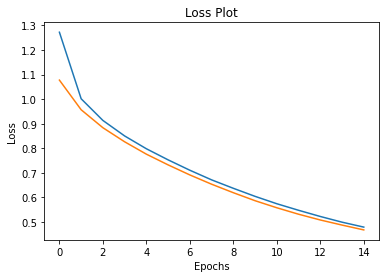

In [59]:
## plotting loss across the epochs
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### NOTE: 
* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not. 
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model. 

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

In [60]:
## defining evaluation function
max_length = 35
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    #hidden = decoder.reset_state(batch_size=1)
    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(preprocess_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input) # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)# extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)# get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id =  tf.argmax(predictions[0]).numpy()#extract the predicted id(embedded value) which carries the max value
        result.append(tokenizer.index_word[predicted_id])#map the id to the word from tokenizer and append the value to the result list

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions

### Beam Search(optional)

In [61]:
## importing libraries
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw

In [62]:
## defining beam search evaluation function
def beam_evaluate(image, beam_index = 3):
    max_length=max_l
    start = [tokenizer.word_index['<start>']]
    result = [[start, 0.0]]

    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    while len(result[0][0]) < max_length:
        i=0
        temp = []
        for s in result:
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            i=i+1
            word_preds = np.argsort(predictions[0])[-beam_index:]
          
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
            
                prob += np.log(predictions[0][w])
                    
                temp.append([next_cap, prob])
        result = temp
        result = sorted(result, reverse=False, key=lambda l: l[1])
        result = result[-beam_index:]
        
        
        predicted_id = result[-1]
        pred_list = predicted_id[0]
        
        prd_id = pred_list[-1] 
        if(prd_id!=3):
            dec_input = tf.expand_dims([prd_id], 0)  
        else:
            break
    
    
    result2 = result[-1][0]
    
    intermediate_caption = [tokenizer.index_word[i] for i in result2]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
            
        else:
            break

    attention_plot = attention_plot[:len(result), :]
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [63]:
## defining function to plot image and captions
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [64]:
## importing libraries
from nltk.translate.bleu_score import sentence_bleu

In [65]:
## definin function to filter the captions
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [66]:
features_shape = batch_feat.shape[1]
attention_features_shape = batch_feat.shape[0]

/Users/abhinavjoshi/opt/anaconda3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/abhinavjoshi/opt/anaconda3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BLEU score: 19.06925178491185
Real Caption: a girl throws a frisbee
Prediction Caption: a little girl in a red tracksuit is throwing a frisbee



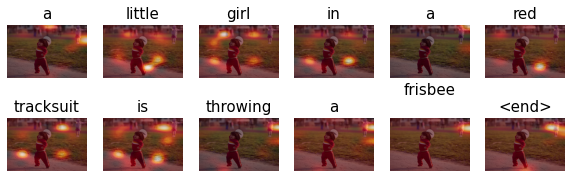

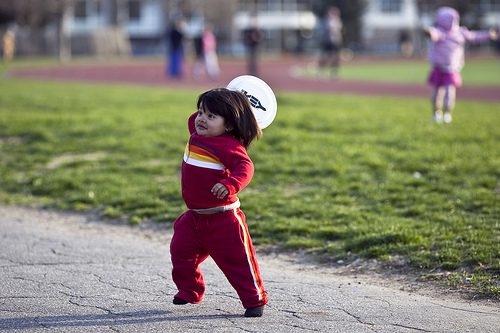

In [70]:
## printing image,real caption, predicted caption and BLEU score
import numpy as np
max_l = 35
## generating random image from the sample
rid = np.random.randint(0, len(path_test))
test_image = path_test[rid]
#test_image = './images/413231421_43833a11f5.jpg'
#real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
print(f"BLEU score: {score*100}")

print('Real Caption:', real_caption)
print('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)